<img src="logo.png" alt="UMU logo" height="10px" width="200px"  style="display:block; margin-left:auto; margin-right:auto;">
<h2> UMU Data Analysis and Visualization </h2>
<h4> Hitanghu Moses Mulongo - 2024-M132-20791 </h4>


<h2> Assignment 4 - R Version </h2>

In [ ]:
install.packages("tidyr")
install.packages("dplyr")

In [79]:

# Load CSV file
data <- read.csv("winequality-white.csv",header = TRUE, sep = ";", stringsAsFactors = FALSE)

head(data)
#data_tbl <- as_tibble(data)
#data_tbl

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
2,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
3,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
6,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6


<h1> 1.0 Data Cleaning </h1>

<h4> Task 1.1: Checking and handling missing values </h4>

In [15]:
#checks for missing values using colsums(is.na(data)) and stores them as a df
missing_table <- data.frame(

  missing_values = colSums(is.na(data))
)

missing_table



,missing_values
,<dbl>
fixed.acidity,0
volatile.acidity,0
citric.acid,0
residual.sugar,0
chlorides,0
free.sulfur.dioxide,0
total.sulfur.dioxide,0
density,0
pH,0


<h6> As we can see there are no missing values in the dataset </h6>

<h2> Task 1.2: Checking  and handling outliers </h2>

In [17]:
# Finction for checking for outliers
check_for_outliers <- function(df){
outlier_summary <- df %>%
  summarise(across(
    where(is.numeric), 
    ~ sum(. < (quantile(., 0.25, na.rm = TRUE) - 1.5 * IQR(., na.rm = TRUE)) |
          . > (quantile(., 0.75, na.rm = TRUE) + 1.5 * IQR(., na.rm = TRUE))),
    .names = "outliers_in_{.col}"
  ))

outlier_summary_long <- outlier_summary %>%
  pivot_longer(
    cols = everything(),
    names_to = "variable",
    values_to = "outlier_count"
  )

# Optional: clean variable names
outlier_summary_long$variable <- gsub("outliers_in_", "", outlier_summary_long$variable)

# Display the result
outlier_summary_long
}

<h2> 1.2.1 displaying outliers </p>

In [21]:
library(tidyr)
library(dplyr)
check_for_outliers(data) # display  outliers



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




variable,outlier_count
<chr>,<int>
fixed.acidity,119
volatile.acidity,186
citric.acid,270
residual.sugar,7
chlorides,208
free.sulfur.dioxide,50
total.sulfur.dioxide,19
density,5
pH,75


<h2>1.2.2 Replace outliers with median</h2>

In [23]:
#library(dplyr)

# Function to replace outliers with mean
replace_outlier_with_median <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  lower <- Q1 - 1.5 * IQR
  upper <- Q3 + 1.5 * IQR
  
  median_no_outlier <- median(x[x >= lower & x <= upper], na.rm = TRUE)
  
  x[x < lower | x > upper] <- median_no_outlier
  return(x)
}

# Apply to all numeric columns
data_clean <- data %>%
  mutate(across(where(is.numeric), replace_outlier_with_median))


<h4> Explanation </h4>

1. Compute Q1, Q3, and IQR for each numeric column.

2. Define lower and upper bounds for outliers.

3. Calculate the mean of values within the bounds (ignoring outliers).

4. Replace all values outside the bounds with this mean.

5. Use mutate(across(...)) to apply it to all numeric columns in the dataframe.

<h2>1.2.3 Checking for outliers again </h2>

In [25]:
check_for_outliers(data_clean) # Checking for outliers 

variable,outlier_count
<chr>,<int>
fixed.acidity,0
volatile.acidity,38
citric.acid,115
residual.sugar,0
chlorides,38
free.sulfur.dioxide,7
total.sulfur.dioxide,0
density,0
pH,17


<p> We still have some outliers so we gonna remove them using winsorization which will replace extreme values with nearest “non-outlier” value instead of removing complete rows</p>


In [27]:

winsorize_outliers <- function(df) {
  # Identify numeric columns
  num_cols <- sapply(df, is.numeric)
  
  # Function to Winsorize a single numeric vector
  winsorize <- function(x) {
    Q1 <- quantile(x, 0.25, na.rm = TRUE)
    Q3 <- quantile(x, 0.75, na.rm = TRUE)
    IQR <- Q3 - Q1
    lower <- Q1 - 1.5 * IQR
    upper <- Q3 + 1.5 * IQR
    
    x[x < lower] <- lower
    x[x > upper] <- upper
    return(x)
  }
  
  # Apply Winsorization to all numeric columns
  df[, num_cols] <- lapply(df[, num_cols, drop = FALSE], winsorize)
  
  return(df)
}

df_cleaned <- winsorize_outliers(data_clean)


In [29]:
# Checking for outliers again
check_for_outliers(df_cleaned)

variable,outlier_count
<chr>,<int>
fixed.acidity,0
volatile.acidity,0
citric.acid,0
residual.sugar,0
chlorides,0
free.sulfur.dioxide,0
total.sulfur.dioxide,0
density,0
pH,0


<p> --- All outliers have been cleaned --- </p>

<h4> Task 1.3: Checking and handling scales among variable</h4>

In [31]:
# Identify numeric columns
num_cols <- sapply(df_cleaned, is.numeric)

# Get min, max, and range for each numeric column
check_for_scale <- function(df_cleaned){
scale_summary <- data.frame(
  #Column = names(df_cleaned)[num_cols],
  Min = sapply(df_cleaned[, num_cols], min, na.rm = TRUE),
  Max = sapply(df_cleaned[, num_cols], max, na.rm = TRUE),
  Range = sapply(df_cleaned[, num_cols], function(x) max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
)

scale_summary
    }
check_for_scale(df_cleaned)

,Min,Max,Range
,<dbl>,<dbl>,<dbl>
fixed.acidity,4.80000,8.80000,4.0000
volatile.acidity,0.08000,0.46000,0.3800
citric.acid,0.12000,0.52000,0.4000
residual.sugar,0.60000,22.00000,21.4000
chlorides,0.01650,0.06850,0.0520
free.sulfur.dioxide,2.00000,78.00000,76.0000
total.sulfur.dioxide,21.00000,255.00000,234.0000
density,0.98711,1.00241,0.0153
pH,2.82000,3.54000,0.7200


<p>variables are not on the same scale. we will rescale usin min-max scale</p>

<h2> 1.3.2: Scaling variables using min-max</h2>

In [33]:
df_cleaned[, num_cols] <- lapply(df_cleaned[, num_cols], function(x) {
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
})
check_for_scale(df_cleaned)

,Min,Max,Range
,<dbl>,<dbl>,<dbl>
fixed.acidity,0,1,1
volatile.acidity,0,1,1
citric.acid,0,1,1
residual.sugar,0,1,1
chlorides,0,1,1
free.sulfur.dioxide,0,1,1
total.sulfur.dioxide,0,1,1
density,0,1,1
pH,0,1,1


<P> All variables has been rescaled and all values follow between 0 and 1 </p>

<h1> Task 2: Feature analysis </h2>

In [35]:
# Load required libraries
library(caret)      # for nearZeroVar
library(corrplot)   # for correlation plots

# Check low variance features
nzv <- nearZeroVar(df_cleaned, saveMetrics = TRUE)
nzv



Loading required package: ggplot2

Loading required package: lattice

corrplot 0.95 loaded



,freqRatio,percentUnique,zeroVar,nzv
,<dbl>,<dbl>,<lgl>,<lgl>
fixed.acidity,1.472414,0.89832585,FALSE,FALSE
volatile.acidity,1.619772,1.53123724,FALSE,FALSE
citric.acid,1.530945,0.83707636,FALSE,FALSE
residual.sugar,1.016304,6.22703144,FALSE,FALSE
chlorides,1.950249,1.10249081,FALSE,FALSE
free.sulfur.dioxide,1.012500,2.08248265,FALSE,FALSE
total.sulfur.dioxide,1.045455,4.79787668,FALSE,FALSE
density,1.049180,18.10943242,FALSE,FALSE
pH,1.156977,1.49040425,FALSE,FALSE


<h4> Interpretation </h4>
1. zeroVar: None of the columns have zero variance (all FALSE), so all have some variation.

2. nzv: All columns are FALSE, so no columns are flagged as near-zero variance.

<b>Conclusion: </b> The dataset does not have any near-zero variance features, so there is no need to remove any column based on NZV.

<h4> Correlation Analysis Visualization </h4>

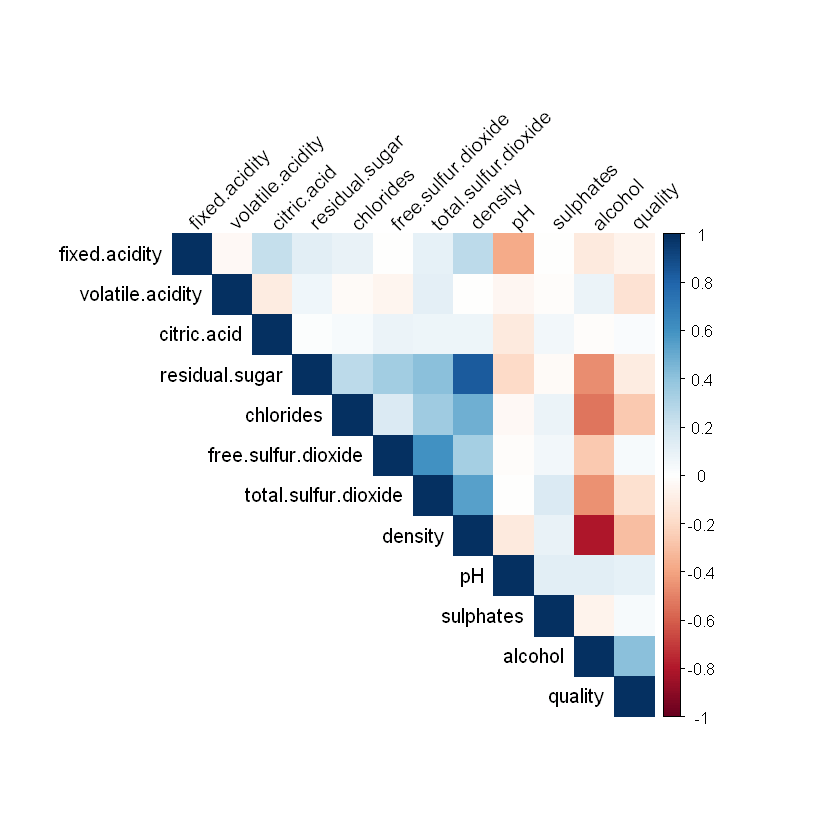

In [37]:
# Correlation analysis
cor_matrix <- cor(df_cleaned)
corrplot(cor_matrix, method = "color", type = "upper", tl.col = "black", tl.srt = 45)


<h4>Interpretation: </h4>

1. Color Scale

- Dark blue (close to +1): Strong positive correlation. As one variable increases, the other also increases.

- Dark red (close to -1): Strong negative correlation. As one variable increases, the other decreases.

- White (around 0): Little to no linear relationship.

2. Diagonal

The diagonal is always 1 (perfect correlation with itself), so it’s dark blue.

3. Notable Relationships

- Alcohol vs Quality: Positive correlation (blue). Higher alcohol tends to be associated with higher wine quality.

- Volatile Acidity vs Quality: Negative correlation (red). Higher volatile acidity is linked to lower quality.

- Sulphates vs Quality: Slight positive correlation (blue). More sulphates tend to slightly increase wine quality.

- Density vs Alcohol: Strong negative correlation (red). Higher alcohol wines tend to have lower density.

- Residual Sugar vs Density: Positive correlation (blue). More residual sugar means higher density.

- Free SO₂ vs Total SO₂: Strong positive correlation (blue). They naturally move together.

4. Insights

- Variables like alcohol and sulphates are helpful in predicting wine quality.

- Volatile acidity is a negative quality factor.

- Some variables (e.g., pH, chlorides) show weak correlations with quality, so they may not be strong predictors.

<h1> Task 3: Dimensionality Reduction  </h1>

<h3> Method 1: PCA </h3>
Principal Component Analysis is usually applied when variables are correlated with each other (multicollinearity). Highly correlated variables carry overlapping information, so PCA can reduce them into fewer components while preserving variance.
<p> According to the headmap above we make the following observations; </p>
<h4> 1. Strong Correlations (Candidates for Dimensionality Reduction) </h4>

- residual.sugar ↔ density (positive correlation) → These two largely measure the same underlying effect (sweetness contributing to density).

- free.sulfur.dioxide ↔ total.sulfur.dioxide (positive correlation) → Since free SO₂ is a part of total SO₂, they overlap strongly.

- fixed.acidity ↔ citric.acid (moderate correlation) → Wines with higher fixed acidity often have higher citric acid.

- density ↔ alcohol (negative correlation) → Alcohol decreases density, so these are inversely related.

<h4>2.Weakly or Independently Correlated (To be kept) </h4>

- volatile.acidity (negatively correlated with quality, not redundant).

- sulphates (slight positive correlation with quality, not highly redundant).

- chlorides (not strongly correlated with most others).

- pH (not strongly correlated, carries unique info).

- quality (target variable, never reduced).

<h4>Conclusion</h4>

Running PCA, the features that will most likely to be compressed into fewer components are:

- residual.sugar, density, alcohol

- free.sulfur.dioxide, total.sulfur.dioxide

- fixed.acidity, citric.acid

The rest (volatile.acidity, sulphates, chlorides, pH) are fairly independent and provide unique signals, so PCA might not reduce them much.

Warning message in geom_bar(stat = "identity", fill = barfill, color = barcolor, :
"Ignoring empty aesthetic: `width`."


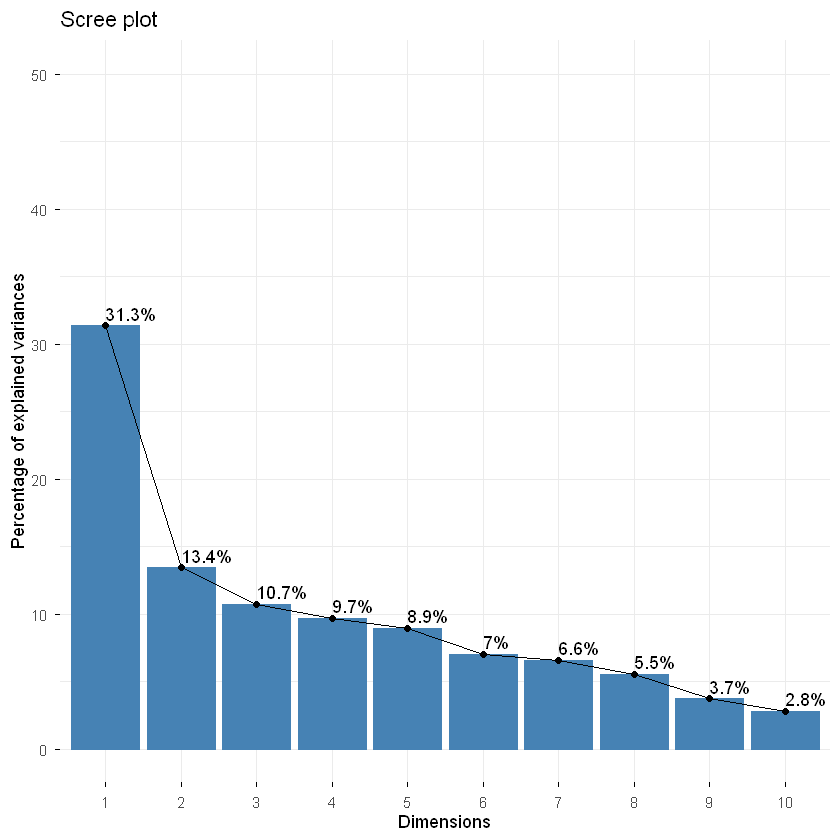

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.7897943,-0.92069560,-1.01936426,0.05708036,-0.5171908,0.6666667
2,-0.4418288,0.71970520,0.01888733,-1.17335435,0.9602007,0.6666667
3,0.3888277,-1.31452336,0.32539267,-0.68281012,0.4638058,0.6666667
4,1.9118558,0.04104956,0.05023533,-0.28033237,-0.7196517,0.6666667
5,1.9118558,0.04104956,0.05023533,-0.28033237,-0.7196517,0.6666667
6,0.3888277,-1.31452336,0.32539267,-0.68281012,0.4638058,0.6666667


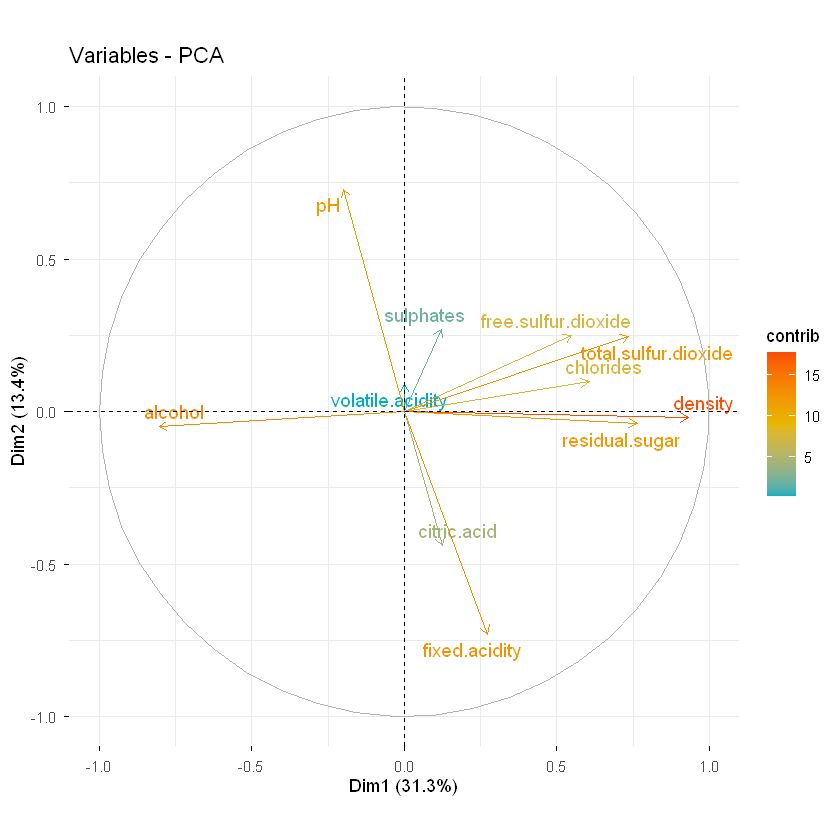

In [54]:
# Load libraries
library(FactoMineR)
library(factoextra)

# Assuming your data frame is "wine"
# Remove target variable (quality)
wine_features <- df_cleaned[, !(names(df_cleaned) %in% c("quality"))]

# Scale features before PCA
wine_scaled <- scale(wine_features)

# Run PCA
pca_res <- PCA(wine_scaled, graph = FALSE)

# Scree plot: variance explained by each PC
fviz_eig(pca_res, addlabels = TRUE, ylim = c(0, 50))

# Variable contributions
fviz_pca_var(pca_res, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE)


# Add back the target variable "quality"
wine_reduced <- cbind(pca_scores, quality = df_cleaned$quality)

# Preview new dataset
head(wine_reduced)


<p> --- Features were reduced from 9 to only 6 by PCA --- </p>
The visualization of the experiened variance from PCA shows that the dataset should be perfectly reduced to 2 dimensions

<h3> Method 2: UMAP </h3>

,X1,X2,quality
,<dbl>,<dbl>,<dbl>
1,1.1856648,-2.5166353,0.6666667
2,1.5880355,2.8874259,0.6666667
3,0.7824226,1.3060133,0.6666667
4,2.5779430,0.4979243,0.6666667
5,2.5694484,0.4750052,0.6666667
6,0.7796451,1.2689379,0.6666667


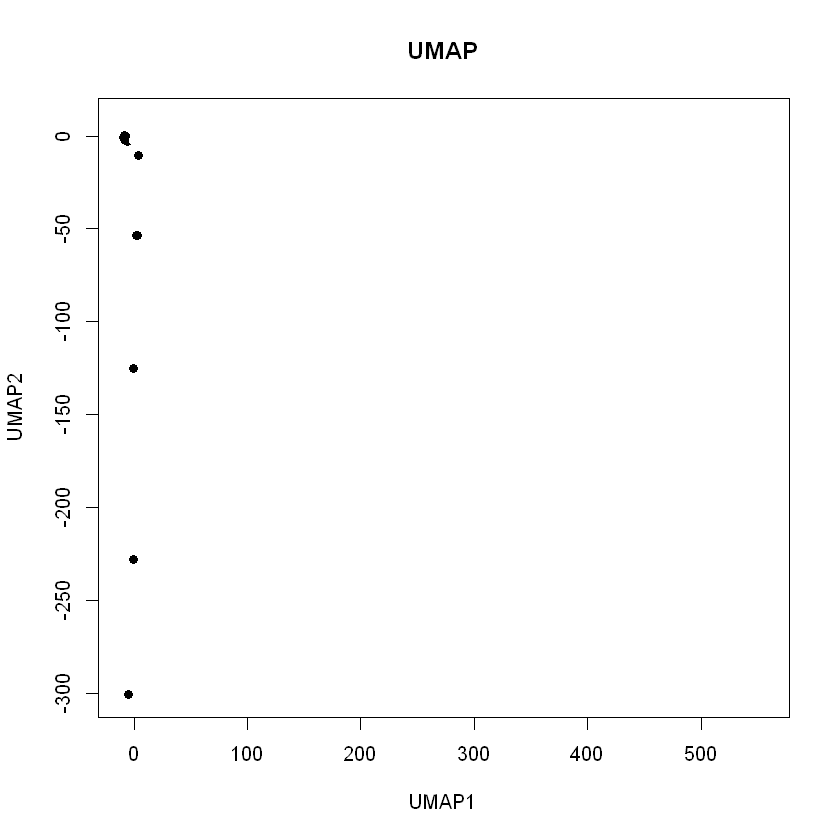

In [66]:
library(umap)

# Run UMAP
set.seed(123)
umap_res <- umap(df_cleaned)

# Convert to dataframe
umap_data <- data.frame(umap_res$layout, quality = df_cleaned$quality)
#view reduced dataset
head(umap_data)
# Plot
plot(umap_data$X1, umap_data$X2,
     col = umap_data$quality, pch = 19,
     xlab = "UMAP1", ylab = "UMAP2", main = "UMAP")


 --- UMAP Reduced to features to only two, perfectly as indicate by the bell curve on PCA's explained variance --

<b> Reflection:  </b>

Feature Analysis: Low variance features add little information. Highly correlated features introduce redundancy. Removing them improves efficiency without losing predictive power.

<b> Interpretability vs Accuracy:</b>

- PCA is easiest to interpret (linear combinations of original features).

- UMAP are less interpretable but highlight complex nonlinear structures.

- Trade-off: better visualization vs harder interpretability.

<b> END OF ASSIGNMENT </b>